In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import nltk
import re
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import dgl

from torch.utils.data import Dataset, DataLoader
from allennlp.modules.elmo import Elmo, batch_to_ids
from eunjeon import Mecab
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from dgl.dataloading import GraphDataLoader
from dgl.data.utils import load_graphs
from sklearn.metrics import accuracy_score, recall_score, f1_score


In [2]:
# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [3]:
data_dir = '../analysis_files/files/'
data_dir2 = '../analysis_files/word2vec/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# mecab 모델 다운로드
tokenizer = Mecab()

In [4]:
def load_dataset(data_dir):
    df = pd.read_csv(os.path.join(data_dir, '감성대화말뭉치(최종데이터)_Validation.csv'), encoding='cp949')
    df = df[['사람문장1', '감정_대분류', '상황키워드']]

    # NaN values and empty strings removal
    df.dropna(subset=['사람문장1'], inplace=True)
    df = df[df.astype(str).ne('').all(axis=1)]

    # Label encoding
    emotion_encoder = LabelEncoder()
    df['emotion'] = emotion_encoder.fit_transform(df['감정_대분류'])
    situation_encoder = LabelEncoder()
    df['situation'] = situation_encoder.fit_transform(df['상황키워드'])

    # Create label mapping dictionaries
    emotion_mapping = dict(zip(emotion_encoder.classes_, emotion_encoder.transform(emotion_encoder.classes_)))
    situation_mapping = dict(zip(situation_encoder.classes_, situation_encoder.transform(situation_encoder.classes_)))

    # Data split
    train_df, test_df = train_test_split(df, test_size=0.1, random_state=seed)
    
    return train_df, test_df, emotion_mapping, situation_mapping

In [5]:
train_df, test_df, emotion_mapping, situation_mapping = load_dataset(data_dir)

# Print the label mappings
print("Emotion Label Mapping:")
for emotion, encoded_label in emotion_mapping.items():
    print(f"{emotion}: {encoded_label}")

print("\nSituation Label Mapping:")
for situation, encoded_label in situation_mapping.items():
    print(f"{situation}: {encoded_label}")

Emotion Label Mapping:
기쁨: 0
당황: 1
분노: 2
불안: 3
상처: 4
슬픔: 5

Situation Label Mapping:
가족관계: 0
건강: 1
건강,죽음: 2
대인관계: 3
대인관계(부부, 자녀): 4
연애,결혼,출산: 5
재정: 6
재정,은퇴,노후준비: 7
직장, 업무 스트레스: 8
진로,취업,직장: 9
학교폭력/따돌림: 10
학업 및 진로: 11


In [6]:
train_df.head()

,사람문장1,감정_대분류,상황키워드,emotion,situation
1468,아이들 키우느라 은퇴 준비를 별도로 마련하지 못했는데 하루아침에 갑자기 해고 통지를...,불안,재정,3,6
4857,생각보다 빨리 은퇴를 해야 할 것 같은데 준비를 어떻게 해야 할지 당혹스러워.,불안,"재정,은퇴,노후준비",3,7
2166,나는 엄마를 요양원에 보내자는 언니의 말에 찬성하지 않아.,불안,대인관계,3,3
5010,오늘 학교가 개교기념일이어서 공부를 하지 않아서 좋아.,기쁨,학업 및 진로,0,11
3808,회사의 업무 부조리에 대해 개선을 요구했는데 그것 때문에 따돌림을 받게 되었어.,상처,"직장, 업무 스트레스",4,8


In [7]:
utterance_train = train_df['사람문장1'].tolist()
label_emotion_train = train_df['emotion'].tolist()
label_situation_train = train_df['situation'].tolist()
utterance_test = test_df['사람문장1'].tolist()
label_emotion_test = test_df['emotion'].tolist()
label_situation_test = test_df['situation'].tolist()

print('훈련용 문장의 수 :', len(utterance_train))
print('훈련용 감정레이블의 수 :', len(label_emotion_train))
print('훈련용 원인레이블의 수 :', len(label_situation_train))
print('테스트용 문장의 수 :', len(utterance_test))
print('테스트용 감정레이블의 수 :', len(label_emotion_test))
print('테스트용 원인레이블의 수 :', len(label_situation_test))

훈련용 문장의 수 : 5976
훈련용 감정레이블의 수 : 5976
훈련용 원인레이블의 수 : 5976
테스트용 문장의 수 : 665
테스트용 감정레이블의 수 : 665
테스트용 원인레이블의 수 : 665


<Axes: xlabel='감정_대분류'>

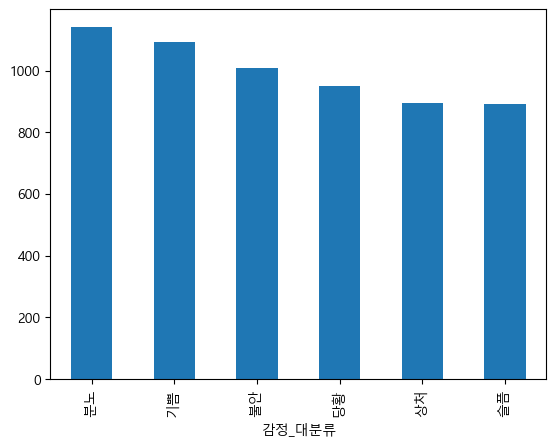

In [8]:
train_df['감정_대분류'].value_counts().plot(kind = 'bar')

<Axes: xlabel='감정_대분류'>

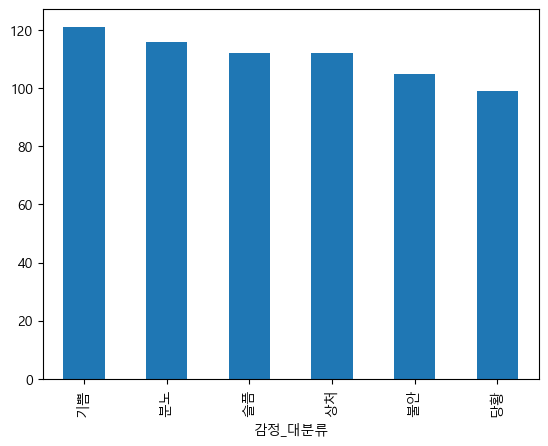

In [9]:
test_df['감정_대분류'].value_counts().plot(kind = 'bar')

<Axes: xlabel='상황키워드'>

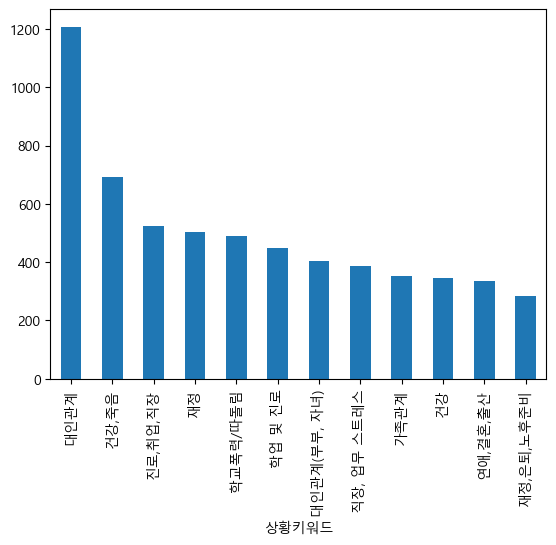

In [10]:
train_df['상황키워드'].value_counts().plot(kind = 'bar')

<Axes: xlabel='상황키워드'>

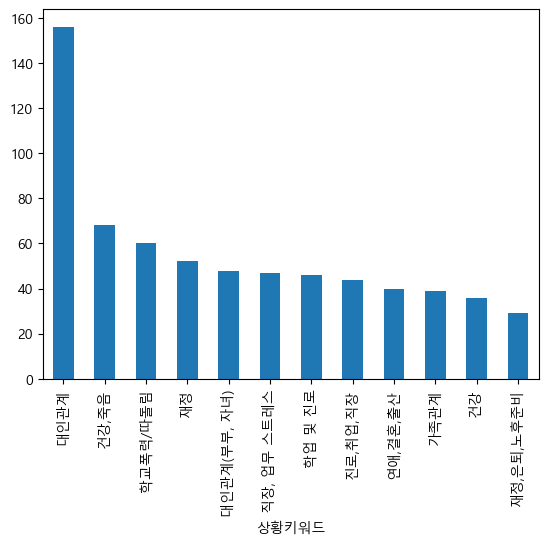

In [11]:
test_df['상황키워드'].value_counts().plot(kind = 'bar')

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['사람문장1'].tolist())
sequences_train = tokenizer.texts_to_sequences(train_df['사람문장1'].tolist())
sequences_test = tokenizer.texts_to_sequences(test_df['사람문장1'].tolist())
sequences_train[:5] # 상위 5개 샘플 출력

[[1838,
  1839,
  213,
  152,
  5141,
  3155,
  3156,
  1840,
  58,
  2307,
  3157,
  261,
  5142,
  5143,
  900],
 [507, 182, 539, 75, 56, 6, 508, 152, 73, 75, 111, 336],
 [12, 1841, 1132, 5144, 2308, 741, 5145, 29],
 [17, 1842, 5146, 189, 138, 94, 52],
 [1133, 292, 5147, 144, 5148, 5149, 5150, 13, 159, 477, 248]]

In [13]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print('단어 집합(Vocabulary)의 크기 :',vocab_size)

단어 집합(Vocabulary)의 크기 : 14517


문장의 최대 길이 : 27
문장의 평균 길이 : 9.667838018741634


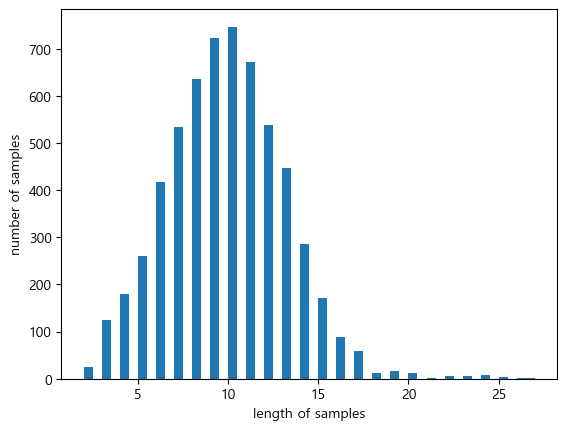

In [14]:
print('문장의 최대 길이 :',max(len(l) for l in sequences_train))
print('문장의 평균 길이 :',sum(map(len, sequences_train))/len(sequences_train))
plt.hist([len(s) for s in sequences_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [15]:
max_len = 30

utterance_train = pad_sequences(sequences_train, maxlen=max_len)
utterance_test = pad_sequences(sequences_test, maxlen=max_len)

label_emotion_train = to_categorical(train_df['emotion'])
label_situation_train = to_categorical(train_df['situation'])
label_emotion_test = to_categorical(test_df['emotion'])
label_situation_test = to_categorical(test_df['situation'])

print('훈련 데이터의 크기(shape):', utterance_train.shape)
print('훈련 데이터 감정레이블의 크기(shape):', label_emotion_train.shape)
print('훈련 데이터 원인레이블의 크기(shape):', label_situation_train.shape)

훈련 데이터의 크기(shape): (5976, 30)
훈련 데이터 감정레이블의 크기(shape): (5976, 6)
훈련 데이터 원인레이블의 크기(shape): (5976, 12)


In [16]:
print('훈련 데이터의 첫번째 샘플 :',utterance_train[0])
print('훈련 데이터의 첫번째 샘플의 감정레이블 :',label_emotion_train[0])
print('훈련 데이터의 첫번째 샘플의 원인레이블 :',label_situation_train[0])

훈련 데이터의 첫번째 샘플 : [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 1838 1839  213  152 5141 3155 3156 1840   58 2307 3157  261 5142
 5143  900]
훈련 데이터의 첫번째 샘플의 감정레이블 : [0. 0. 0. 1. 0. 0.]
훈련 데이터의 첫번째 샘플의 원인레이블 : [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [17]:
indices_train = np.arange(utterance_train.shape[0])
np.random.shuffle(indices_train)
print('랜덤 시퀀스 :',indices_train)

indices_test = np.arange(utterance_test.shape[0])
np.random.shuffle(indices_test)

랜덤 시퀀스 : [5451 3448 1151 ... 2825 1548 4028]


In [18]:
X_train = utterance_train[indices_train]
y_emotion_train = label_emotion_train[indices_train]
y_situation_train = label_situation_train[indices_train]

X_test = utterance_test[indices_test]
y_emotion_test = label_emotion_test[indices_test]
y_situation_test = label_situation_test[indices_test]

In [19]:
embedding_dict = dict()
# 사전 훈련된 Word2Vec 모델을 로드
model = Word2Vec.load(os.path.join(data_dir2, 'ko.bin'))

In [20]:
for word in model.wv.vocab:
    embedding_dict[word] = model.wv[word]
    
print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

30185개의 Embedding vector가 있습니다.


In [21]:
print(embedding_dict['우울'])
print(len(embedding_dict['우울']))

[-1.21498978e+00 -5.43866694e-01  1.32688725e+00 -6.49432898e-01
 -4.38877225e-01  5.52123845e-01  4.83556360e-01  1.02437699e+00
 -2.07902670e-01  1.21977139e+00 -5.29723316e-02  2.83519924e-01
  3.75814110e-01  6.29925787e-01 -5.16617894e-01 -2.62273163e-01
 -1.77138105e-01  7.17207134e-01  1.64666355e-01 -1.71311915e-01
  5.11819899e-01  4.22978140e-02  2.26164639e-01  7.59881958e-02
  3.07586491e-01  6.97090849e-02 -4.44131732e-01  9.51295376e-01
 -9.61420715e-01 -3.31237733e-01  3.33495051e-01 -2.93511562e-02
  4.39231545e-01  2.65127450e-01 -3.65351290e-01 -7.63717890e-01
  7.36222565e-02 -9.49564651e-02  2.45211333e-01  6.11337125e-01
 -1.75878897e-01  6.61108434e-01  1.19337216e-02 -8.98760736e-01
  9.82642323e-02  5.10104120e-01 -3.21627408e-01  2.17479408e-01
  3.48298520e-01  1.51318341e-01 -2.26444125e-01  3.23872238e-01
 -6.18719637e-01  9.16367769e-01 -7.72069275e-01 -2.47000799e-01
 -4.40212220e-01  1.47606462e-01  2.45241672e-01  6.81707561e-01
 -1.40714899e-01  3.91073

In [22]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
print('임베딩 테이블의 크기(shape) :',np.shape(embedding_matrix))


임베딩 테이블의 크기(shape) : (14517, 200)


In [23]:
for word, i in word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [24]:
kernel_sizes = [2, 3, 5]
num_filters = 512
dropout_ratio = 0.5

model_input = Input(shape=(max_len,))
output = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                      input_length=max_len, trainable=False)(model_input)

conv_blocks = []

for size in kernel_sizes:
    conv = Conv1D(filters=num_filters,
                         kernel_size=size,
                         padding="valid",
                         activation="relu",
                         strides=1)(output)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)

output = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
output = Dropout(dropout_ratio)(output)



In [25]:
# Emotion classification model
num_emotion_classes = len(emotion_mapping)
model_output_emotion = Dense(num_emotion_classes, activation='softmax')(output)
model_emotion = Model(model_input, model_output_emotion)

model_emotion.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model_emotion.summary()

history_emotion = model_emotion.fit(X_train, y_emotion_train,
                                    batch_size=32,
                                    epochs=100,
                                    validation_data=(X_test, y_emotion_test))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 30, 200)              2903400   ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 29, 512)              205312    ['embedding[0][0]']           
                                                                                                  
 conv1d_1 (Conv1D)           (None, 28, 512)              307712    ['embedding[0][0]']           
                                                                                              

In [26]:
# Situation classification model
num_situation_classes = len(situation_mapping)
model_output_situation = Dense(num_situation_classes, activation='softmax')(output)
model_situation = Model(model_input, model_output_situation)

model_situation.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model_situation.summary()

history_situation = model_situation.fit(X_train, y_situation_train,
                                        batch_size=32,
                                        epochs=100,
                                        validation_data=(X_test, y_situation_test))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 30, 200)              2903400   ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 29, 512)              205312    ['embedding[0][0]']           
                                                                                                  
 conv1d_1 (Conv1D)           (None, 28, 512)              307712    ['embedding[0][0]']           
                                                                                            

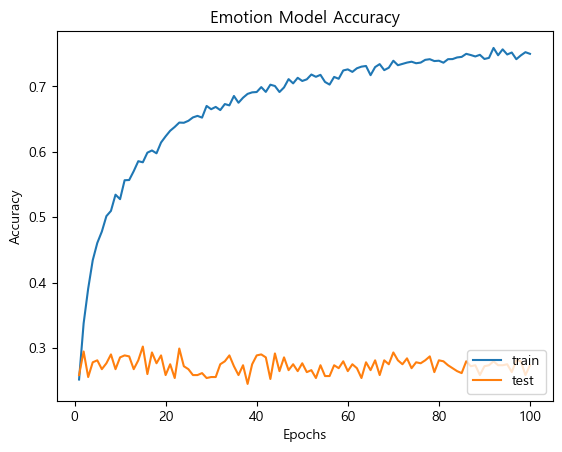

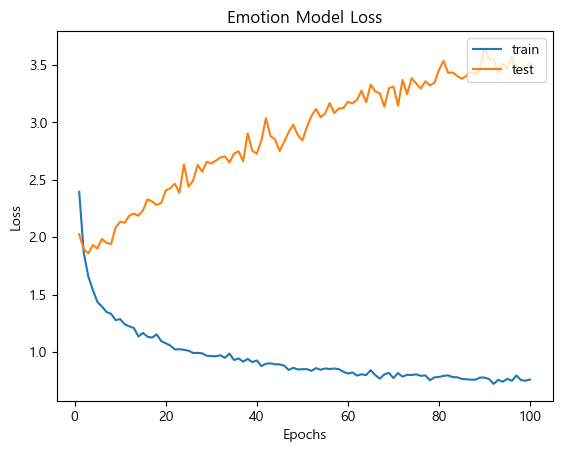

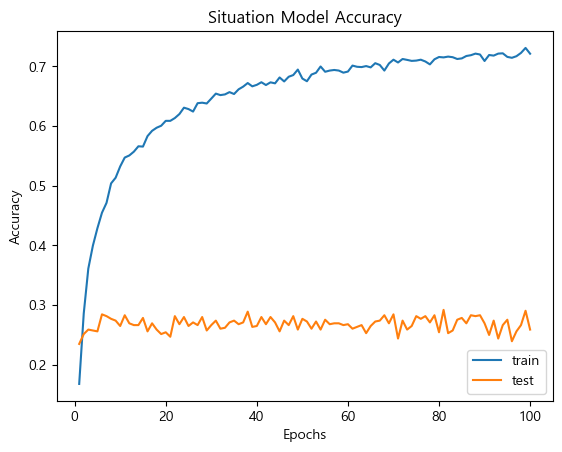

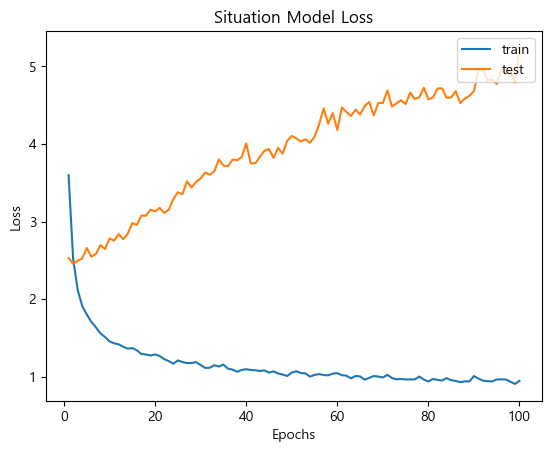

In [27]:
# Plot accuracy and loss graphs for emotion classification
epochs = range(1, len(history_emotion.history['acc']) + 1)
plt.plot(epochs, history_emotion.history['acc'])
plt.plot(epochs, history_emotion.history['val_acc'])
plt.title('Emotion Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

epochs = range(1, len(history_emotion.history['loss']) + 1)
plt.plot(epochs, history_emotion.history['loss'])
plt.plot(epochs, history_emotion.history['val_loss'])
plt.title('Emotion Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Plot accuracy and loss graphs for situation classification
epochs = range(1, len(history_situation.history['acc']) + 1)
plt.plot(epochs, history_situation.history['acc'])
plt.plot(epochs, history_situation.history['val_acc'])
plt.title('Situation Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

epochs = range(1, len(history_situation.history['loss']) + 1)
plt.plot(epochs, history_situation.history['loss'])
plt.plot(epochs, history_situation.history['val_loss'])
plt.title('Situation Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [28]:
# Combine emotion and situation labels
y_combined_train = np.concatenate((y_emotion_train, y_situation_train), axis=1)
y_combined_test = np.concatenate((y_emotion_test, y_situation_test), axis=1)

# Emotion and situation classification model
num_combined_classes = len(emotion_mapping) + len(situation_mapping)
model_output_combined = Dense(num_combined_classes, activation='softmax')(output)
model_combined = Model(model_input, model_output_combined)

model_combined.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model_combined.summary()

history_combined = model_combined.fit(X_train, y_combined_train,
                                      batch_size=32,
                                      epochs=100,
                                      validation_data=(X_test, y_combined_test))

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 30, 200)              2903400   ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 29, 512)              205312    ['embedding[0][0]']           
                                                                                                  
 conv1d_1 (Conv1D)           (None, 28, 512)              307712    ['embedding[0][0]']           
                                                                                            

In [29]:
# Emotion classification model
num_emotion_classes = len(emotion_mapping)
model_output_emotion = Dense(num_emotion_classes, activation='softmax')(output)
model_emotion = Model(model_input, model_output_emotion)

model_emotion.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model_emotion.summary()

history_emotion = model_emotion.fit(X_train, y_emotion_train,
                                    batch_size=32,
                                    epochs=100,
                                    validation_data=(X_test, y_emotion_test))

# Situation classification model
num_situation_classes = len(situation_mapping)
model_output_situation = Dense(num_situation_classes, activation='softmax')(output)
model_situation = Model(model_input, model_output_situation)

model_situation.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model_situation.summary()

history_situation = model_situation.fit(X_train, y_situation_train,
                                        batch_size=32,
                                        epochs=100,
                                        validation_data=(X_test, y_situation_test))

# Evaluate both models on the test data
emotion_eval_results = model_emotion.evaluate(X_test, y_emotion_test)
situation_eval_results = model_situation.evaluate(X_test, y_situation_test)

print("Emotion classification accuracy:", emotion_eval_results[1])
print("Situation classification accuracy:", situation_eval_results[1])

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 30, 200)              2903400   ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 29, 512)              205312    ['embedding[0][0]']           
                                                                                                  
 conv1d_1 (Conv1D)           (None, 28, 512)              307712    ['embedding[0][0]']           
                                                                                            